# Introduction to PySpark and MLlib


This notebook contains basic materials and examples/exercises on using pyspark for machine learning via Spark's MLlib (Spark version 1.4.1). 

https://spark.apache.org/docs/1.4.1/mllib-guide.html

For first time users of IPython notebook, the code cells below can be run directly from this note book either by pressing the "play" icon on the top , or by hitting CTRL+ Enter key. The profile setup for this IPyThon notebook allows PySpark API to be called directly from the code cells below. On top of that, the Anaconda Python distribution has also been installed which include common libraries such as numpy, scikit-learn, scipy, pandas etc. 

This exercise will go through the building of a machine learning pipeline with MLlib for classification purpose.
The exercise includes:
- loading the data into Spark dataframe
- preprocessing the raw data
- feature extraction/transformation
- train classification model
- create machine learning pipeline to wrap the featurization and classifications
- hyperparameters tuning and cross validation
- testing the model and visualizing the results






In [126]:
import pip

#uncomment the line below if you wish to view the available python modules
#sorted(["%s==%s" % (i.key, i.version) for i in pip.get_installed_distributions()])
 


## Prediction for Bank direct marketing Campaign

The following exercises on PySpark will be applied to a classifcation problem on a data set obtained from UCI Machine Learning Repository.

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

This data has already been loaded into your VM and its available under the data/ folder which you can view from Jupyter.

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). This is basically a binary classifcation, where the predicted classes is either yes or no.
Some of the headings has been renamed for clarity purpose.

###Attribute Information:

| Position | Heading | Description | Values |       
| :- |:-- |:------------------------------------ | :------------|
|1| age (numeric)  | | |
|2| job  | |'admin.','blue-collar','entrepreneur','housemaid', 'management','retired','self-employed','services','student','technician','unemployed','unknown'|
|3| marital  | | 'divorced','married','single','unknown'|
|4| education | |'basic.4y','basic.6y','basic.9y','high.school', 'illiterate','professional.course','university.degree','unknown'|
|5| default | has credit in default? | 'no','yes','unknown'|
|6| housing | has housing loan?  | 'no','yes','unknown'|
|7| loan | has personal loan? | 'no','yes','unknown'|
|8| contact | contact communication type  | 'cellular','telephone'|
|9| month | last contact month of year| 'jan', 'feb', 'mar', ..., 'nov', 'dec'|
|10| day_of_week |last contact day of the week|'mon','tue','wed','thu','fri'|
|11| duration |last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.||
|12| campaign |number of contacts performed during this campaign and for this client (numeric, includes last contact)||
|13| pdays |number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)||
|14| previous |number of contacts performed before this campaign and for this client (numeric)||
|15| outcome_of_prev | outcome of the previous marketing campaign |'failure','nonexistent','success'|
|16| emp_variation_rate | employment variation rate - quarterly indicator (numeric) ||
|17|consumer_price_idx | consumer price index - monthly indicator (numeric)  ||
|18|consumer_conf_idx| consumer confidence index - monthly indicator (numeric)   ||
|19|euribor3m|euribor 3 month rate - daily indicator (numeric)  ||
|20|num_of_employees|number of employees - quarterly indicator (numeric) ||
|21|has_subscribed|has the client subscribed a term deposit?  Note: This is not an attribute, rather the label of the observations | 'yes','no'|



#  First up, Loading the data

SparkSql core supports various datasource such as Parquet, Json , Avro etc.
However for CSV, it requires to use additional Spark Package. Currently theres the following options of spark-csv by Databricks guys, and pyspark_csv. Pyspark_csv was selected due to its better performances in inferring the schema, as compared to spark-csv which seems still a bit less flexible, and defaults all columns to string types.


In [1]:
import os.path
import pyspark_csv as pycsv


#import the spark package for importing csv
sc.addPyFile('pyspark_csv.py')

#read in the csv data file
fileName = os.path.join('data', 'bank-additional-full-data.csv')
plainTextRdd = sc.textFile(fileName)
rawDataFrame = pycsv.csvToDataFrame(sqlContext, plainTextRdd, parseDate=False)

#Have a look at the schema of the data frame created
rawDataFrame.printSchema()


#we can convert this to panda dataframe if we want to
#pandaDf = rawDataFrame.toPandas()

#Alternatively, csv can be loaded via the spark-csv package. Not using this because 
#by default all fields are read in as String for CSV :(
#rawDataFrame = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load(fileName)


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- outcome_of_prev: string (nullable = true)
 |-- emp_variation_rate: double (nullable = true)
 |-- consumer_price_idx: double (nullable = true)
 |-- consumer_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- num_employees: double (nullable = true)
 |-- has_subscribed: string (nullable = true)



## Data Preprocessing

Preprocess the data if required.

As noted above, the "duration" column should not be used as part of the features as it wont be known till phone calls.
So next step we going to remove the duration column. 

The label column currently is in string format. But the MLlib classifiers such as Logistic regression and decision trees expect the Dataframe to contain the following structures for training:
    - "features" : single vector column representing the feature vectors for the observation 
    - "label": double type, representing the label
    
There's no missing values in the datasets. If replacement of missing values is required, we could use the Dataframe.fillna function (similar to pandas).


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import UserDefinedFunction

# Number of records
print "Number of observations originally: %s" % rawDataFrame.count()
print "Number of columns originally: %s" % len(rawDataFrame.columns)

#Remove duration column as its only for benchmark purpose. We wont know duration till after we know the outcome of
#whether the customer signed up for the term deposit.
filteredDf = rawDataFrame.drop("duration")

print "Number of filtered observations: %s" % filteredDf.count()
print "Number of columns now: %s" % len(filteredDf.columns)
filteredDf.describe("age").show()

#Add the label column , that basically corresponds to the has_subscribed column
toDouble = UserDefinedFunction(lambda x: 1. if x == "yes" else 0., DoubleType())
filteredDf = filteredDf.withColumn("label", toDouble(filteredDf["has_subscribed"]))
filteredDf.show(3)


Number of observations originally: 41188
Number of columns originally: 21
Number of filtered observations: 41188
Number of columns now: 20
+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             41188|
|   mean| 40.02406040594348|
| stddev|10.421123471838722|
|    min|                17|
|    max|                98|
+-------+------------------+

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|outcome_of_prev|emp_variation_rate|consumer_price_idx|consumer_conf_idx|euribor3m|num_employees|has_subscribed|label|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+----

+--------------+-----+
|has_subscribed|count|
+--------------+-----+
|            no|36548|
|           yes| 4640|
+--------------+-----+



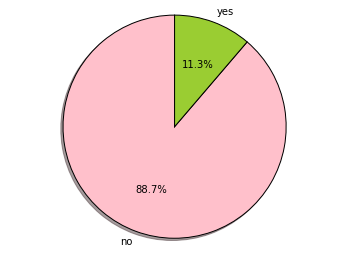

In [3]:
import matplotlib.pyplot as plt

#Show number of customers that have signed up term deposit vs those that did not
numOfSignUps = filteredDf.groupBy("has_subscribed").count()
numOfSignUps.show()

labels = numOfSignUps.map(lambda row: row.has_subscribed).collect()
sizes = numOfSignUps.map(lambda row: row.count).collect()
colors = ['pink', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors, shadow=True,autopct='%1.1f%%', startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()


## Creating Datasets

We will need 3 sets of data,
- training set : for training our classification models
- validation set : for evaluating the performance of our trained models (and hyperparameters tuning)
- test set: for testing the models (unseen samples, not used in training nor model selection)

Our goal is to create model that can generalized well to the dataset, to avoid overfitting.



In [4]:
# split into training, validation and test datasets
trainingRdd, validationRdd, testRdd = filteredDf.rdd.randomSplit([6, 2, 2], seed=0L)
trainingDf = trainingRdd.toDF() 
validationDf = validationRdd.toDF() 
testDf = testRdd.toDF() 

#lets cache these datasets
trainingDf.cache()
validationDf.cache()
testDf.cache()


print "Num of training observations : %s" % trainingDf.count()
print "Num of validation observations : %s" % validationRdd.count()
print "Num of test observations : %s" % testDf.count()

Num of training observations : 24721
Num of validation observations : 8225
Num of test observations : 8242


## Categorical Feature Transform/Extraction

For the categorical attributes, we need to convert those text-based categories into numeric features before attempting to train/build a classification model with these data. 

For example, the attribute of "marital", is a categorical feature with 4 possible values of 'divorced','married','single','unknown'. 

We will be using the out-of-the-box MLlib featurization technique named one hot encoding to transform such categorical features into a feature vectors consist of a set of numeric values (binary 0 and 1 in this case). Refer to the MLLib documentation for more information about one hot encoding
https://spark.apache.org/docs/latest/api/python/pyspark.ml.html






In [7]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#encode the categorical attributes (Refer to the table at the top)
categoricalAttributes = ['job', 'marital', 'education', 'default', 
                         'housing', 'loan', 'contact', 
                         'month', 'day_of_week', 'outcome_of_prev']

#Build a list of pipelist stages for the machine learning pipeline. 
#start by the feature transformer of one hot encoder for building the categorical features
pipelineStages = []
for columnName in categoricalAttributes:
    stringIndexer = StringIndexer(inputCol=columnName, outputCol=columnName+ "Index")
    pipelineStages.append(stringIndexer)
    oneHotEncoder = OneHotEncoder(inputCol=columnName+ "Index", outputCol=columnName + "Vec")
    pipelineStages.append(oneHotEncoder)


print "%s string indexer and one hot encoders transformers" %  len(pipelineStages) 
assert len(pipelineStages) == len(categoricalAttributes)*2

# Combine all the feature columns into a single column in the dataframe
numericColumns = ['age', 'campaign', 'pdays', 'previous',
           'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 'euribor3m', 'num_employees']

categoricalCols = [s + "Vec" for s in categoricalAttributes]
allFeatureCols =  numericColumns + categoricalCols
vectorAssembler = VectorAssembler(
    inputCols=allFeatureCols,
    outputCol="features")
pipelineStages.append(vectorAssembler)

featurePipeline = Pipeline(stages=pipelineStages)

print "feature columns: %s" % allFeatureCols

20 string indexer and one hot encoders transformers
feature columns: ['age', 'campaign', 'pdays', 'previous', 'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 'euribor3m', 'num_employees', 'jobVec', 'maritalVec', 'educationVec', 'defaultVec', 'housingVec', 'loanVec', 'contactVec', 'monthVec', 'day_of_weekVec', 'outcome_of_prevVec']


## Creating Machine Learning Pipeline

In the previous steps, we have chain together a list of feature encoders to encode our categorical features.
Next we will proceed to use MLlib Pipeline api to build the ML pipeline. The advantage of the pipeline API is that its higher level API and more modular. 

https://spark.apache.org/docs/latest/ml-guide.html#migration-guide





In [8]:
from pyspark.ml.classification import LogisticRegression

# Configure an machine learning pipeline, which consists of the 
# transformers (stringIndexer + one hot encoders + vector assembler)
# and estimator (a linear regression)
lr = LogisticRegression(maxIter=10, regParam=0.01)
completeStages = pipelineStages + [lr]
mlPipeline = Pipeline(stages=completeStages)

# Fit the pipeline to training data.
firstPipelineModel = mlPipeline.fit(testDf)


# Evaluating the model on training data
trainingResults = firstPipelineModel.transform(trainingDf)
labelsAndPreds = trainingResults.map(lambda p: (p.label, p.prediction))
trainAccuracy = labelsAndPreds.filter(lambda (l, p): l == p).count() / float(labelsAndPreds.count())
print "=========================================="
print("Training accuracy (%) = " + str(trainAccuracy* 100))
print "=========================================="


Training accuracy (%) = 89.9761336516


In [9]:
# Run the prediction with our trained model on test data (which has not been used in training)
# Make predictions on test observations and print results.
prediction = firstPipelineModel.transform(testDf)
selected = prediction.select("has_subscribed", "label","rawPrediction","probability", "prediction")
selected.show(50)

+--------------+-----+--------------------+--------------------+----------+
|has_subscribed|label|       rawPrediction|         probability|prediction|
+--------------+-----+--------------------+--------------------+----------+
|            no|  0.0|[2.87596446619375...|[0.94664540433528...|       0.0|
|            no|  0.0|[2.78794640810369...|[0.94202098453235...|       0.0|
|            no|  0.0|[3.29499307213042...|[0.96425664367089...|       0.0|
|            no|  0.0|[2.78554305189142...|[0.94188957981401...|       0.0|
|            no|  0.0|[2.83458372074327...|[0.94451630314769...|       0.0|
|            no|  0.0|[3.00623802201272...|[0.95285514554613...|       0.0|
|            no|  0.0|[3.07098416843018...|[0.95567987640093...|       0.0|
|            no|  0.0|[3.20031628538030...|[0.96084617784691...|       0.0|
|            no|  0.0|[3.27727378630684...|[0.96364088556458...|       0.0|
|            no|  0.0|[2.77871559442571...|[0.94151475912177...|       0.0|
|           

## Clustering - unsupervised classification...

MLLib offers some clustering methods. This could be useful when you are dealing with unlabeled data, where its impossible to apply supervised learning algorithms. On the other hand, even for labelled, it may be good for exploratory purpose to see the outcome of clustering on the training dataset.

List of supporting clustering techniques out of the box by Spark currently are:
- K-means
- Gaussian mixture
- Power iteration clustering (PIC)
- Latent Dirichlet allocation (LDA)
- Streaming k-means


In [10]:
from pyspark.mllib.clustering import KMeans, KMeansModel, GaussianMixture
from numpy import array
from math import sqrt

# Extract the "features" from the training set into vector format for GMM 
trainingFeatures = trainingResults.select("features").rdd.map(lambda row: row.features)

# Build the model (cluster the data)
numOfClusters = 2
gmm = GaussianMixture.train(trainingFeatures, numOfClusters)

# output parameters of model
#for i in range(2):
#    print ("weight = ", gmm.weights[i], "mu = ", gmm.gaussians[i].mu,
#        "sigma = ", gmm.gaussians[i].sigma.toArray())

# Predict with GMM cluster model
predictedLabels = gmm.predict(trainingFeatures).collect()
actualLabels = trainingResults.select("label").rdd.map(lambda row: row.label).zipWithIndex()
actualAndPred = actualLabels.map(lambda (l, i): (l, predictedLabels[i]))
gmmAccuracy = actualAndPred.filter(lambda (l, p): l == p).count() / float(actualAndPred.count())
print "=========================================="
print("GMM accuracy against training set(%) = " + str(gmmAccuracy* 100))
print "=========================================="


GMM accuracy against training set(%) = 88.9688928441
